In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.preprocessing import StandardScaler

#### read in train/test sets

In [2]:
df_train_sets = pd.read_pickle('ebw_poc_train_sample_expt3_with_shf_aligned_h1.pkl')
df_test_sets  = pd.read_pickle('ebw_poc_test_sample_expt3_with_shf_aligned_h1.pkl')

In [3]:
mask_train = (df_train_sets.index.get_level_values(3) <= 26)
mask_test = (df_test_sets.index.get_level_values(3) <= 26)
df_train_sets = df_train_sets.loc[mask_train]
df_test_sets = df_test_sets.loc[mask_test]

#### read in GBM model

In [4]:
file_gbm='best_est_gbm_h1_expt3_with_aligned_shf_nocorr.pkl'
with open(file_gbm, 'rb') as file:
    best_estimators_gbm = pickle.load(file)

#### plot learning curve

In [5]:
id_cols = list(df_train_sets.index)
target_cols = ['censoring_flg_mod', 'target']
cat_cols = ['market_name']
feature_cols = list(set(df_train_sets.columns) - set(target_cols))
num_cols = list(set(feature_cols) -set(cat_cols))

In [6]:
split_number = 5
random_state = 1000
weeks_range = range(27)

In [7]:
best_estimators_gbm[0]

as_concordance_index_ipcw_scorer(estimator=GradientBoostingSurvivalAnalysis(learning_rate=0.5,
                                                                            max_depth=10,
                                                                            max_features='sqrt',
                                                                            min_samples_leaf=16,
                                                                            min_samples_split=8,
                                                                            n_estimators=200),
                                 tau=1000)

In [8]:
from sklearn.model_selection import learning_curve, cross_val_score
from sksurv.metrics import concordance_index_ipcw, as_concordance_index_ipcw_scorer, cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

def concordance_scorer_ipcw(estimator, X, y):
    return estimator.score(X, y)

#### predicted risk scores

In [9]:
preds_train = {}
surv_fn_train = {}
preds_test = {}
surv_fn_test = {}

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    # scores_train[wk] = estimator.score(X_train[estimator.estimator.feature_names_in_], y_train)
    preds_train[wk] = estimator.predict(X_train[estimator.estimator.feature_names_in_])
    # surv_fn_train[wk] = estimator.predict_survival_function(X_train[estimator.estimator.feature_names_in_])

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    X_test.drop(drop_cols, axis=1, inplace=True)
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    preds_test[wk] = estimator.predict(X_test[estimator.estimator.feature_names_in_].loc[test_idx])
    # surv_fn_test[wk] = estimator.predict_survival_function(X_test[estimator.estimator.feature_names_in_].loc[test_idx])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']


In [10]:
df_train_sets['pred'] = np.nan
df_test_sets['pred'] = np.nan

In [11]:
for wk in weeks_range:
    # print(df_train_sets[df_train_sets.index.get_level_values(3) == wk].shape)
    df_train_sets.loc[df_train_sets.index.get_level_values(3) == wk, 'pred'] = preds_train[wk]
    df_test_sets.loc[df_test_sets.index.get_level_values(3) == wk, 'pred'] = preds_test[wk]
    # print(len(preds_train[wk]))

In [12]:
# assign format quintile for train/test sets
df_train_sets['format_quintile'] = df_train_sets.groupby(['weeks_since_hit']).apply(
    lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0])
df_test_sets['format_quintile'] = df_test_sets.groupby(['weeks_since_hit']).apply(
    lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0])

In [13]:
# assign station quintile for train/test sets
df_train_sets['station_quintile'] = df_train_sets.groupby(['weeks_since_hit', 'call_letters']).apply(
    lambda x: pd.qcut(x['pred'], q=5, labels=False, duplicates='drop')).droplevel([0,1])
df_test_sets['station_quintile'] = df_test_sets.groupby(['weeks_since_hit', 'call_letters']).apply(
    lambda x: pd.qcut(x['pred'], q=5, labels=False, duplicates='drop')).droplevel([0,1])

In [14]:
# normalize risk score by format
df_train_sets['pred_normalized_format'] = df_train_sets.groupby(['weeks_since_hit']).apply(lambda x: (x['pred'] - x['pred'].min())/(x['pred'].max() - x['pred'].min())).droplevel([0])

df_test_sets['pred_normalized_format'] = df_test_sets.groupby(['weeks_since_hit']).apply(lambda x: (x['pred'] - x['pred'].min())/(x['pred'].max() - x['pred'].min())).droplevel([0])

In [15]:
# normalize risk score by station
df_train_sets['pred_normalized_station'] = df_train_sets.groupby(['weeks_since_hit', 'call_letters']).apply(lambda x: (x['pred'] - x['pred'].min())/(x['pred'].max() - x['pred'].min())).droplevel([0,1])

df_test_sets['pred_normalized_station'] = df_test_sets.groupby(['weeks_since_hit', 'call_letters']).apply(lambda x: (x['pred'] - x['pred'].min())/(x['pred'].max() - x['pred'].min())).droplevel([0,1])

In [15]:
# format quintile rank
df_train_sets.groupby(['weeks_since_hit', 'station_quintile'])['pred_normalized_format'].rank()

mediabase_id  call_letters  week_dt     weeks_since_hit
2591406       WNCI-FM       2021-09-26  0.0                 91.0
                            2021-10-03  1.0                155.0
                            2021-10-10  2.0                149.0
                            2021-10-17  3.0                116.0
                            2021-10-24  4.0                139.0
                                                           ...  
2598403       WXKS-FM       2021-02-07  22.0                81.0
                            2021-02-14  23.0                59.0
                            2021-02-21  24.0                32.0
                            2021-02-28  25.0                71.0
                            2021-03-07  26.0                30.0
Name: pred_normalized_format, Length: 19630, dtype: float64

In [ ]:
df_train_sets

#### predicted survival curves and MAPE for survival time point prediction

In [18]:
from sksurv.functions import StepFunction
# define function to extract point estimate of survival time from survival curves
def get_percentile_from_step_fn(step_fns_list, percs):
    surv_time_preds=[]
    try:
        for step_fn in step_fns_list:
            idxs = [np.argmin(step_fn.y[step_fn.y >=alpha]) for alpha in percs]
            surv_time_pred = [step_fn.x[idx] for idx in idxs]
            surv_time_preds.append(surv_time_pred)
    except ValueError:
        return
    return surv_time_preds

In [19]:
def get_prob_from_step_fn(step_fns_list, spins):
    surv_time_preds=[]
    try:
        for step_fn in step_fns_list:
            idxs = [np.argmin(step_fn.x[step_fn.x >=alpha]) for alpha in spins]
            surv_time_pred = [step_fn.y[idx] for idx in idxs]
            surv_time_preds.append(surv_time_pred)
    except ValueError:
        return
    return surv_time_preds

In [20]:
df_surv_time = pd.DataFrame()
df_surv_time_test = pd.DataFrame()

df_surv_prob_test_all = pd.DataFrame()

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    surv_fn_train = estimator.predict_survival_function(X_train[estimator.estimator.feature_names_in_])

    alphas = list(np.arange(0,1,0.1)) + [0.25, 0.50, 0.75, 0.95, 0.99]
    alphas = list(np.sort(alphas))
    alphas = [0.10, 0.50, 0.90]
    surv_time_preds = get_percentile_from_step_fn(surv_fn_train, alphas)
    # df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=X_train.index)
    df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=[f'stp_perc_{int(100*i)}' for i in alphas], index=X_train.index)
    df_surv_time_preds = pd.concat([df_surv_time_preds, df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_surv_time = pd.concat([df_surv_time, df_surv_time_preds])

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    # print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    surv_fn_test = estimator.predict_survival_function(X_test[estimator.estimator.feature_names_in_].loc[test_idx])

    surv_time_preds_test = get_percentile_from_step_fn(surv_fn_test, alphas)
    # df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=test_idx)
    df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=[f'stp_perc_{int(100*i)}' for i in alphas], index=test_idx)
    df_surv_time_preds_test = pd.concat([df_surv_time_preds_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_surv_time_test = pd.concat([df_surv_time_test, df_surv_time_preds_test])


    # surv_prob_test = get_prob_from_step_fn(surv_fn_test, [25, 50, 75, 100])
    # # df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=test_idx)
    # df_surv_prob_test = pd.DataFrame(surv_prob_test, columns=[f'prob_{int(i)}' for i in [25, 50, 75, 100]], index=test_idx)
    # df_surv_prob_test = pd.concat([df_surv_prob_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    # df_surv_prob_test_all = pd.concat([df_surv_prob_test_all, df_surv_prob_test])

In [21]:
surv_cols = ['stp_perc_10', 'stp_perc_50', 'stp_perc_90']
df_train_sets = df_train_sets.join(df_surv_time[surv_cols], how='left')
df_test_sets = df_test_sets.join(df_surv_time_test[surv_cols], how='left')

In [22]:
df_train_sets['target_quintile'] = df_train_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['target'], q=5, labels=[4,3,2,1,0])).droplevel([0,1])

##### predicted cumulative hazard functions

In [24]:
def get_cuml_hazard_from_step_fn(step_fns_list, spins):
    cuml_hazard_preds=[]
    try:
        for step_fn in step_fns_list:
            cuml_hazard_pred = [step_fn.y[idx] for idx in spins]
            cuml_hazard_preds.append(cuml_hazard_pred)
    except ValueError:
        return
    return cuml_hazard_preds

In [28]:
df_cuml_hazard = pd.DataFrame()
df_cuml_hazard_test = pd.DataFrame()

df_surv_prob_test_all = pd.DataFrame()

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    cuml_hazard_fn_train = estimator.predict_cumulative_hazard_function(X_train[estimator.estimator.feature_names_in_])

    spins = list(range(0, 110, 10))
    cuml_hazard_preds = get_cuml_hazard_from_step_fn(cuml_hazard_fn_train, spins)
    # df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=X_train.index)
    df_cuml_hazard_preds = pd.DataFrame(cuml_hazard_preds, columns=[f'cuml_hazard_{int(i)}' for i in spins], index=X_train.index)
    df_cuml_hazard_preds = pd.concat([df_cuml_hazard_preds, df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_cuml_hazard = pd.concat([df_cuml_hazard, df_cuml_hazard_preds])

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    # print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    cuml_hazard_fn_test = estimator.predict_cumulative_hazard_function(X_test[estimator.estimator.feature_names_in_].loc[test_idx])

    cuml_hazard_preds_test = get_cuml_hazard_from_step_fn(cuml_hazard_fn_test, spins)
    # df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=X_train.index)
    df_cuml_hazard_preds_test = pd.DataFrame(cuml_hazard_preds_test, columns=[f'cuml_hazard_{int(i)}' for i in spins], index=X_test.index)
    df_cuml_hazard_preds_test = pd.concat([df_cuml_hazard_preds_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_cuml_hazard_test = pd.concat([df_cuml_hazard_test, df_cuml_hazard_preds_test])


    # surv_prob_test = get_prob_from_step_fn(surv_fn_test, [25, 50, 75, 100])
    # # df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=test_idx)
    # df_surv_prob_test = pd.DataFrame(surv_prob_test, columns=[f'prob_{int(i)}' for i in [25, 50, 75, 100]], index=test_idx)
    # df_surv_prob_test = pd.concat([df_surv_prob_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    # df_surv_prob_test_all = pd.concat([df_surv_prob_test_all, df_surv_prob_test])

In [29]:
df_cuml_hazard_test

,,,,cuml_hazard_0,cuml_hazard_10,cuml_hazard_20,cuml_hazard_30,cuml_hazard_40,cuml_hazard_50,cuml_hazard_60,cuml_hazard_70,cuml_hazard_80,cuml_hazard_90,cuml_hazard_100,censoring_flg_mod,target
mediabase_id,call_letters,week_dt,weeks_since_hit,,,,,,,,,,,,,
2742545,KDHT-FM,2022-04-24,0.0,0.0000,2.673883e-09,2.648047e-08,1.047978e-07,3.514035e-07,5.626495e-07,0.000001,0.000002,0.000004,0.000008,0.000016,False,1515.0
2780771,KHTS-FM,2022-06-19,0.0,0.0000,2.673883e-09,2.648047e-08,1.047978e-07,3.514035e-07,5.626495e-07,0.000001,0.000002,0.000004,0.000008,0.000016,False,1491.0
2638380,WDCG-FM,2021-04-18,0.0,0.0000,2.673883e-09,2.648047e-08,1.047978e-07,3.514035e-07,5.626495e-07,0.000001,0.000002,0.000004,0.000008,0.000016,False,673.0
2345779,WKSC-FM,2021-02-28,0.0,0.0000,2.673883e-09,2.648047e-08,1.047978e-07,3.514035e-07,5.626495e-07,0.000001,0.000002,0.000004,0.000008,0.000016,False,208.0
2553815,WKSC-FM,2021-10-03,0.0,0.0000,2.673883e-09,2.648047e-08,1.047978e-07,3.514035e-07,5.626495e-07,0.000001,0.000002,0.000004,0.000008,0.000016,False,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552613,WZFT-FM,2020-10-11,26.0,0.0067,2.659608e-02,4.830365e-02,6.851265e-02,1.086368e-01,1.281511e-01,0.178334,0.214389,0.239304,0.271001,0.310715,True,176.0
2548688,KKRZ-FM,2020-09-13,26.0,0.0067,2.659608e-02,4.830365e-02,6.851265e-02,1.086368e-01,1.281511e-01,0.178334,0.214389,0.239304,0.271001,0.310715,True,492.0
2582475,KHTS-FM,2021-10-17,26.0,0.0067,2.659608e-02,4.830365e-02,6.851265e-02,1.086368e-01,1.281511e-01,0.178334,0.214389,0.239304,0.271001,0.310715,True,16.0


(0.0, 0.25)

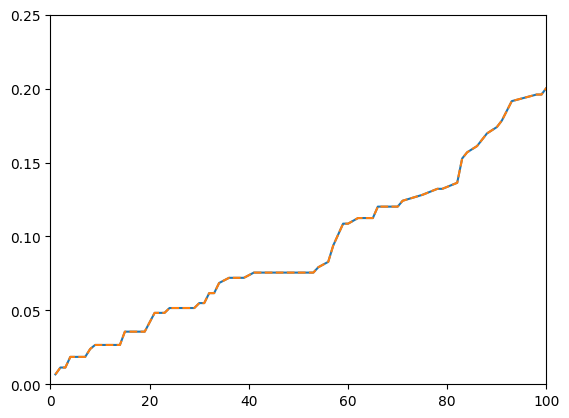

In [36]:
plt.plot(cuml_hazard_fn_test[0].x, cuml_hazard_fn_test[0].y)
plt.plot(cuml_hazard_fn_test[140].x, cuml_hazard_fn_test[140].y, linestyle='--')
plt.xlim([0, 100])
plt.ylim([0, 0.25])

In [37]:
from sqlalchemy import create_engine


def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine


# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()


# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

#create db engine
engine = postgresql_engine(username, password, url, port, database)

In [39]:
sql_cols = ['pred', 'pred_normalized_format', 'pred_normalized_station','format_quintile', 'station_quintile','stp_perc_10', 'stp_perc_50', 'stp_perc_90', 'target','censoring_flg_mod']
with engine.connect() as conn:
    with conn.begin():
        df_train_sets[sql_cols].to_sql('ebw_train_set_h1', con=conn, schema='adds_temp', method='multi', if_exists='replace')
        df_test_sets[sql_cols].to_sql('ebw_test_set_h1', con=conn, schema='adds_temp', method='multi', if_exists='replace')

In [40]:
import pandas as pd
df_raw_features = pd.read_pickle('ebw_raw_features_base_h1.pkl')

In [41]:
df_raw_features_cuml_spins = pd.read_pickle('ebw_raw_features_base_cuml_spins_h1.pkl')

In [ ]:
df_raw_features.head()

In [3]:
df_raw_features.dtypes

mediabase_id               int64
song_id                    int64
call_letters              object
market_name               object
artist_id                  int64
                           ...  
market_spins_non_on        int64
market_spins_am_pm_dr      int64
station_spins_total        int64
station_spins_non_on       int64
station_spins_am_pm_dr     int64
Length: 79, dtype: object

In [7]:
[list(df_raw_features.columns).remove('hit_spins_bucket')]

[None]

In [3]:
pd.DataFrame(df_raw_features.columns)

,0
0,mediabase_id
1,song_id
2,call_letters
3,market_name
4,artist_id
...,...
74,market_spins_non_on
75,market_spins_am_pm_dr
76,station_spins_total
77,station_spins_non_on


In [45]:
df_test_unique = df_test_sets.reset_index()[['mediabase_id', 'call_letters']].drop_duplicates()

In [46]:
df_raw_features_test_set = df_test_unique.join(df_raw_features.set_index(['mediabase_id', 'call_letters']),
                                               on=['mediabase_id', 'call_letters'], how='inner')

In [47]:
df_raw_features_test_set_cuml_spins = df_test_unique.join(df_raw_features_cuml_spins.set_index(['mediabase_id', 'call_letters']),
                                               on=['mediabase_id', 'call_letters'], how='inner')

In [29]:
df_raw_features_test_set_cuml_spins

,mediabase_id,call_letters,week_dt,weeks_since_hit,cuml_song_station_spins_non_on,cuml_song_station_spins_non_on_at_hit
0,2742545,KDHT-FM,2022-03-20,-5.0,58,540.0
0,2742545,KDHT-FM,2022-03-27,-4.0,153,540.0
0,2742545,KDHT-FM,2022-04-03,-3.0,250,540.0
0,2742545,KDHT-FM,2022-04-10,-2.0,347,540.0
0,2742545,KDHT-FM,2022-04-17,-1.0,444,540.0
...,...,...,...,...,...,...
6652,2584541,WDCG-FM,2023-02-26,90.0,3816,958.0
6652,2584541,WDCG-FM,2023-03-05,91.0,3826,958.0
6652,2584541,WDCG-FM,2023-03-12,92.0,3830,958.0
6652,2584541,WDCG-FM,2023-03-19,93.0,3839,958.0


In [49]:
mask = (df_raw_features_test_set['weeks_since_hit'] >= -8) & (df_raw_features_test_set['weeks_since_hit'] <= 36)
df_raw_features_test_set = df_raw_features_test_set.loc[mask]

In [50]:
with engine.connect() as conn:
    with conn.begin():
        df_raw_features_test_set.drop(['hit_spins_bucket'], axis=1).to_sql('ebw_raw_features_h1', con=conn, schema='adds_temp', method='multi', if_exists='replace', chunksize=10000, index=False)

In [43]:
df_train_unique = df_train_sets.reset_index()[['mediabase_id', 'call_letters']].drop_duplicates()
df_raw_features_train_set = df_train_unique.join(df_raw_features.set_index(['mediabase_id', 'call_letters']),
                                               on=['mediabase_id', 'call_letters'], how='inner')
df_raw_features_train_set_cuml_spins = df_train_unique.join(
    df_raw_features_cuml_spins.set_index(['mediabase_id', 'call_letters']),
    on=['mediabase_id', 'call_letters'], how='inner')

mask = (df_raw_features_train_set['weeks_since_hit'] >= -8) & (df_raw_features_train_set['weeks_since_hit'] <= 36)
df_raw_features_train_set = df_raw_features_train_set.loc[mask]

with engine.connect() as conn:
    with conn.begin():
        df_raw_features_train_set.drop(['hit_spins_bucket'], axis=1).to_sql('ebw_raw_features_h1_train', con=conn,
                                                                           schema='adds_temp', method='multi',
                                                                           if_exists='replace', chunksize=10000,
                                                                           index=False)

In [ ]:
df_sub = df_test_sets

In [ ]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile_all', 'censoring_flg_mod'])[['target']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile_all', 'censoring_flg_mod'])['target'].mean(), rsuffix='_r').reset_index().to_excel('test_target_h1.xlsx')

In [ ]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile_all'])[['target']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile_all'])['target'].mean(), rsuffix='_r')

In [ ]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile'])[['burn_before_100_flg']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile'])['burn_before_100_flg'].sum(), rsuffix='_r')